In [2]:
using Plots
using StatsBase
using Statistics
pyplot()

include("ARMA_Generator.jl")
include("wiener_filter_scalar.jl")

wiener_filter_NT (generic function with 1 method)

In [3]:
# Graph stuff
Nex = 1000;
Theta = 2pi*(0:Nex)/Nex;
Z = map(th -> exp(im*th),Theta);

In [22]:
steps = 10^4
discard = 10^3
l = [1, -5/4, 3/8]
pred_full = ARMA_gen(l, steps = steps);

w = [1, -5/3, 4, -20/3];
sig = ARMA_gen([],w, steps = steps - discard, e = pred_full);

pred = pred_full[discard + 1:steps];

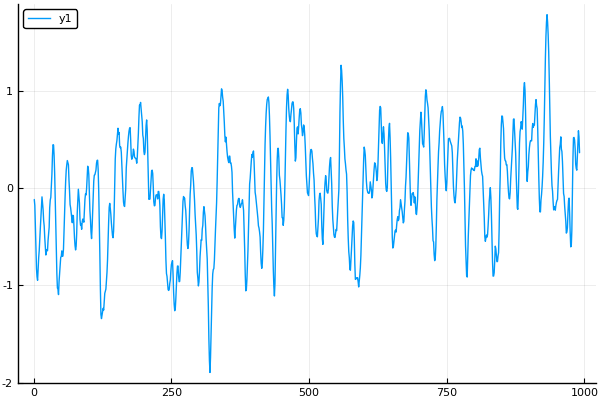

In [23]:
lag = 1000; lags = 10:lag;
C = crosscov(sig,pred,lags)





In [81]:
M_in = 70
N = 500
M_out = 30
# h = wiener_filter_NT(pred, sig, M_in, N, M_out)

# function wiener_filter_NT(pred,sig,M_in,N,M_out)
# pred are the predictors
# sig is the sequence to be approximated
# M is the degree of the approximating Laurent polynomials

# Approximate autocorr and crosscor (Laurent degree M)
M = M_in
R_pred    = autocov(pred,0:M);

R_predsig = crosscov(pred,sig, -M:M)

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2]

R_pred = R_pred.*lam
R_predsig = R_predsig.*[reverse(lam[2:M+1]); lam]

l = Scalar_CKMS_c(R_pred);

z_spect_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])
z_spect_plus_num(z) = z_spect_minus_num(z)'

z_spect_sigpred(z) = sum([R_predsig[i]*z^(M+1 - i) for i = 1: 2*M + 1])

#   Now we us FFT to complete the calculations
N
Nh = Int(floor(N/2))
Z_N = exp.(2*pi*im/N*(0:N-1))
Theta_N = 2*pi/N*(0:N-1)
S_plus_invS_sigpred_fft = fft(z_spect_sigpred.(Z_N)./
                              z_spect_plus_num.(Z_N))/N
S_plus_invS_sigpred_coef = S_plus_invS_sigpred_fft[1:Nh];

S_plus_invS_sigpred_coef_N = [S_plus_invS_sigpred_coef; zeros(N-Nh)]
z_spect_invS_sigpred_plus = ifft(S_plus_invS_sigpred_coef_N)*N

HH =  fft(z_spect_invS_sigpred_plus./
         z_spect_minus_num.(Z_N))/N

M = M_out
h = HH[1:M]
# end

30-element Array{Complex{Float64},1}:
    0.02209359814631899 - 1.5571055827286626e-18im
    0.02441394219502748 - 1.1688641115958319e-18im
    0.01757916109407788 - 1.1564131382214725e-18im
   0.006828457446202439 - 3.7665169452546495e-18im
  0.0006022214551842794 - 4.794794349709417e-18im 
  0.0015183824904318475 - 3.6635905038867534e-18im
  0.0013367675030286122 - 4.67600934291421e-18im  
  -0.005675302271579905 - 9.319038377436131e-18im 
  -0.015485788593697258 - 1.5620889782926977e-17im
  -0.021899806454254378 - 1.8508229690237337e-17im
   -0.02072330754167967 - 1.7928671883181536e-17im
   -0.01682708711004616 - 1.8396117866266276e-17im
  -0.015503271885603468 - 2.0582645668608768e-17im
                        ⋮                         
  -0.018610281250355385 - 3.28353697864528e-17im  
  -0.016980941441008753 - 3.0612823740529074e-17im
  -0.016442233386155088 - 3.1064846967444904e-17im
  -0.016599989746751937 - 3.787734758674105e-17im 
   -0.01156713071440879 - 3.589945491508496e

In [82]:
h = real.(h);

In [83]:
h = 0.01*rand(30)

30-element Array{Float64,1}:
 0.007660995379354856 
 0.0002709965576008311
 0.00974245050815366  
 0.004824450311844517 
 0.005156596783911931 
 0.005322689248153128 
 0.006239575331310136 
 0.006492562157774997 
 0.007122109483517114 
 0.002095863574284054 
 0.0028571530933536836
 0.0017167746519940574
 0.005225633729737851 
 ⋮                    
 0.009550111123083906 
 0.0030528853392242294
 0.009078571171605798 
 0.0023529242659182416
 0.004806213830592274 
 0.006276218598563106 
 0.0008049451641692885
 0.001993382975062461 
 0.0006849509814878618
 0.009640895829387038 
 0.0025759216036460677
 0.0031873207313435816

### Estimated Signal by Wiener Filter

In [84]:
sig_hat = ARMA_gen([],h,steps = steps - discard, discard = discard, e = pred_alt);

z_spect_sig_hat_num = z_spect(sig_hat,100, win = "Tuk");

### Test Orthogonality with Predictors

The Wiener filter, by virture of it being a least squares estimator will produce a prediction errors $Y_n - \hat{Y}_n$ -> `sig[n] - sig_hat[n]` that is uncorrolated with the predictors used $X_m$ -> `pred[m]` for $m \le n$. 

       Before lag = 0          |      after lag = 0 
mean:     -2.402790652195684e-5 | mean:     -6.99819984607249e-6
variance: 1.1339115772928748e-5 | variance: 1.0467967477985658e-5

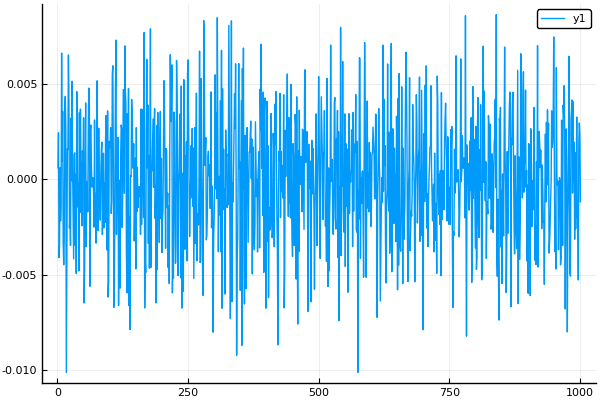

In [85]:
lag = 500
lags = -lag:lag
sig_trunc = sig[1:steps - discard]
pred_trunc = pred[1:steps - discard]
C = crosscov(pred_trunc,(sig_trunc .- sig_hat),lags);
print("       Before lag = 0          |      after lag = 0 ",
    "\nmean:     ", mean(C[1:lag]), " | mean:     ", mean(C[lag+2:end]),
    "\nvariance: ", var(C),         " | variance: ", var(C[lag+2:end]))
plot(C)

### Compare z-spectrum

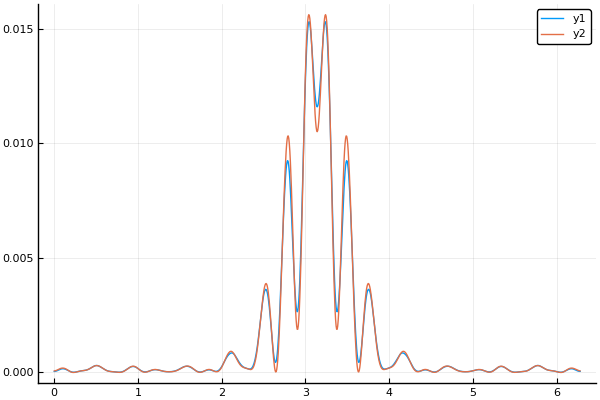

In [86]:
# Wiener filter transfer function
H(z) = Poly(h)(z^(-1));

z_spect_sig_hat_ana(z) = H(z)*z_spect_pred_num(z)*conj( H(conj( z^(-1) )) )

plot(Theta, real.([z_spect_sig_hat_num.(Z) z_spect_sig_hat_ana.(Z)]))

In [87]:
# z-spect of errors
errors = sig_trunc .- sig_hat;
z_spect_errors = z_spect(errors,30, win = "Par");

In [88]:
# cross z-spect sig pred
L_cc_sigpred = 50
A = crosscov(sig_trunc,pred_trunc,0:L_cc_sigpred);
A[1] = .5*A[1]
lam = .5*(1 .+ cos.(pi/L_cc_sigpred*(0:L_cc_sigpred)))
# lam = ones(L_cc_sigpred +1)
z_spect_cross(z) = sum([lam[i+1]*(A[i+1]'*z^(-i) +
                        A[i+1]*z^(i)) for i = 0 : L_cc_sigpred])

z_spect_sig_wf(z) = z_spect_errors(z) + H(z)*conj(z_spect_cross(z)) +
                    conj(H(z))*z_spect_cross(z) - H(z)*z_spect_pred_num(z)*conj(H(z));

Z_errs = z_spect_errors.(Z);
Z_cross1 = map(z -> H(z)*conj(z_spect_cross(z)),Z);
Z_cross2 = map(z -> conj(H(z))*z_spect_cross(z),Z);
Z_sig_hat = map(z -> H(z)*z_spect_pred_num(z)*conj(H(z)),Z);
# plot(Theta, real.([Z_errs Z_cross1 Z_cross2 Z_sig_hat]))

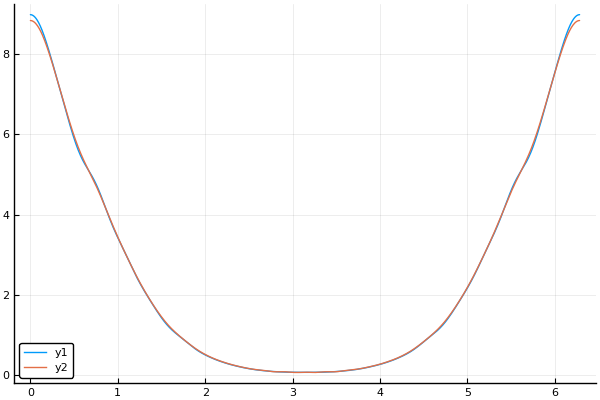

In [89]:
plot(Theta, [real.(z_spect_sig_num.(Z)) real.(z_spect_sig_wf.(Z))])